In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import pennylane as qml
from pennylane.operation import Operation
from pennylane import numpy as np
from functools import reduce
import cirq
from tensorflow import keras
from eqmarl import *
import tensorflow as tf

## Experiments Measuring Various Observables

In [33]:
def run_batch(chunk_size: int, qnode, shape_var, shape_enc, shape_obs):
    tmp_agents_var_thetas = np.random.uniform(low=0., high=np.pi, size=(chunk_size, *shape_var))
    tmp_agents_enc_inputs = np.random.uniform(low=0., high=np.pi, size=(chunk_size, *shape_enc))
    meas = qnode(
        agents_var_thetas=tmp_agents_var_thetas,
        agents_enc_inputs=tmp_agents_enc_inputs,
    )
    meas = np.asarray(meas).T # Reshape so batch dimension is first.
    meas = meas.reshape((-1, *shape_obs)) # Reshape to batched version of observation shape.
    return meas

In [34]:
def experiment_runner(
    n_agents,
    d_qubits,
    n_layers,
    shape_obs,
    observables,
    initial_state = None,
    postprocess_func = None,
    repetitions = 1000,
    batch_size = 32,
    ):

    circuit = MARLCircuit(
        n_agents=n_agents,
        d_qubits=d_qubits,
        n_layers=n_layers,
        initial_state=initial_state,
        observables=observables,
        )
    qnode = circuit.qnode(device='default.qubit')

    func = lambda chunk_size: run_batch(chunk_size, qnode, *circuit.shape, shape_obs)

    x = batched_experiment(
        func=func,
        repetitions=repetitions,
        batch_size=batch_size,
        )

    if postprocess_func is not None:
        x = postprocess_func(x)

    return x

In [35]:
def compute_U_eig(
    n_agents,
    d_qubits,
    n_layers,
    ) -> tuple[NDArray, NDArray, NDArray]:
    """Compute unitary matrix representation for circuit along eith eigenvalues and eigenvectors."""
    
    circuit = MARLCircuit(
    n_agents=n_agents,
    d_qubits=d_qubits,
    n_layers=n_layers,
    )

    shape_var, shape_enc = circuit.shape
    tmp_agents_var_thetas = np.random.uniform(low=0., high=np.pi, size=shape_var)
    tmp_agents_enc_inputs = np.random.uniform(low=0., high=np.pi, size=shape_enc)
    
    
    U = np.asarray(qml.matrix(circuit, wire_order=circuit.wires)(tmp_agents_var_thetas, tmp_agents_enc_inputs))
    eig_vals, eig_vects = cirq.unitary_eig(U)

    return U, eig_vects, eig_vals

In [36]:
def plot_df(
    df,
    title: str = 'Unique actions across all agents',
    plot_func: Callable = plot_df_unique_rows,
    xlabel: str = 'Agent Actions',
    ylabel: str = 'Counts',
    figsize: tuple = None,
    ):
    fig = plt.figure(figsize=figsize)
    ax = fig.subplots(1, 1)
    plot_func(df, ax=ax)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.title(title)
    return fig, ax

### Measuring [Z0@Z1, -(Z0@Z1)]

In [37]:
observables_name = "[Z0@Z1, -(Z0@Z1)]"

/Users/derieux/graduate/research/quantum/eqmarl/eqmarl/experiment.py:303: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=keys, y=values, ax=ax, palette=colors)
/Users/derieux/graduate/research/quantum/eqmarl/eqmarl/experiment.py:306: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


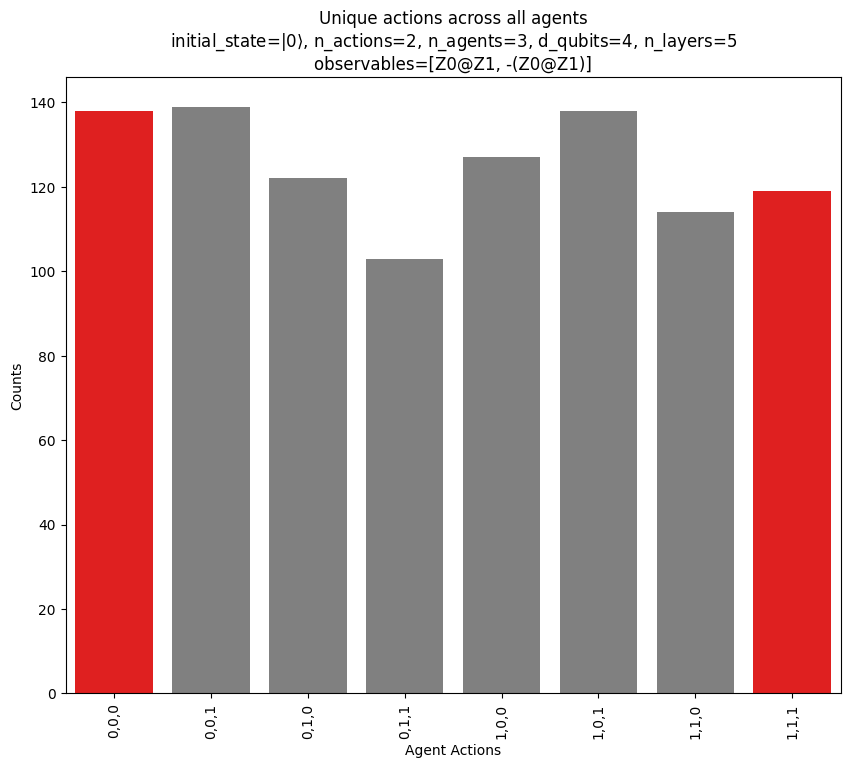

In [38]:
n_actions = 2
n_agents = 3
d_qubits = 4
n_layers = 5
initial_state = None
initial_state_name = '$|0\\rangle$'
shape_obs = (n_agents, n_actions,)
observables = lambda wires: AlternatingGroupedTensorObservables(
    wires=wires,
    n_groups=n_agents,
    d_qubits=d_qubits,
    n_reps=n_actions,
    ) # [Z0@Z1, -(Z0@Z1), Z2@Z3, -(Z2@Z3), ...] for agents with 2 qubits.
postprocess_func = postprocess_measurements_bipolar_softmax
x = experiment_runner(
    n_agents=n_agents,
    d_qubits=d_qubits,
    n_layers=n_layers,
    shape_obs=shape_obs,
    observables=observables,
    initial_state=initial_state,
    postprocess_func=postprocess_func,
    )
df = measurements_to_df(x, column_key='agent')
title = f"Unique actions across all agents\ninitial_state={initial_state_name}, {n_actions=}, {n_agents=}, {d_qubits=}, {n_layers=}\nobservables={observables_name}"
fig, ax = plot_df(df, title=title, figsize=(10,8))

/Users/derieux/graduate/research/quantum/eqmarl/eqmarl/experiment.py:303: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=keys, y=values, ax=ax, palette=colors)
/Users/derieux/graduate/research/quantum/eqmarl/eqmarl/experiment.py:306: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


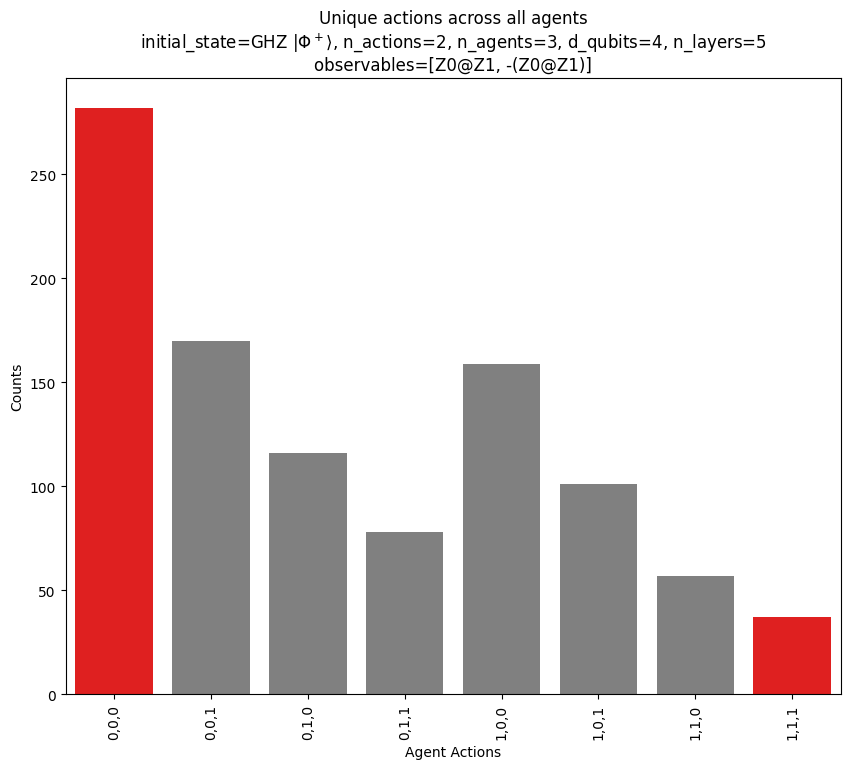

In [39]:
n_actions = 2
n_agents = 3
d_qubits = 4
n_layers = 5
initial_state = lambda wires: entangle_agents_phi_plus(wires=wires, d=d_qubits, n=n_agents)
initial_state_name = 'GHZ $|\Phi^+\\rangle$'
shape_obs = (n_agents, n_actions,)
observables = lambda wires: AlternatingGroupedTensorObservables(
    wires=wires,
    n_groups=n_agents,
    d_qubits=d_qubits,
    n_reps=n_actions,
    ) # [Z0@Z1, -(Z0@Z1), Z2@Z3, -(Z2@Z3), ...] for agents with 2 qubits.
postprocess_func = postprocess_measurements_bipolar_softmax
x = experiment_runner(
    n_agents=n_agents,
    d_qubits=d_qubits,
    n_layers=n_layers,
    shape_obs=shape_obs,
    observables=observables,
    initial_state=initial_state,
    postprocess_func=postprocess_func,
    )
df = measurements_to_df(x, column_key='agent')
title = f"Unique actions across all agents\ninitial_state={initial_state_name}, {n_actions=}, {n_agents=}, {d_qubits=}, {n_layers=}\nobservables={observables_name}"
fig, ax = plot_df(df, title=title, figsize=(10,8))

/Users/derieux/graduate/research/quantum/eqmarl/eqmarl/experiment.py:303: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=keys, y=values, ax=ax, palette=colors)
/Users/derieux/graduate/research/quantum/eqmarl/eqmarl/experiment.py:306: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


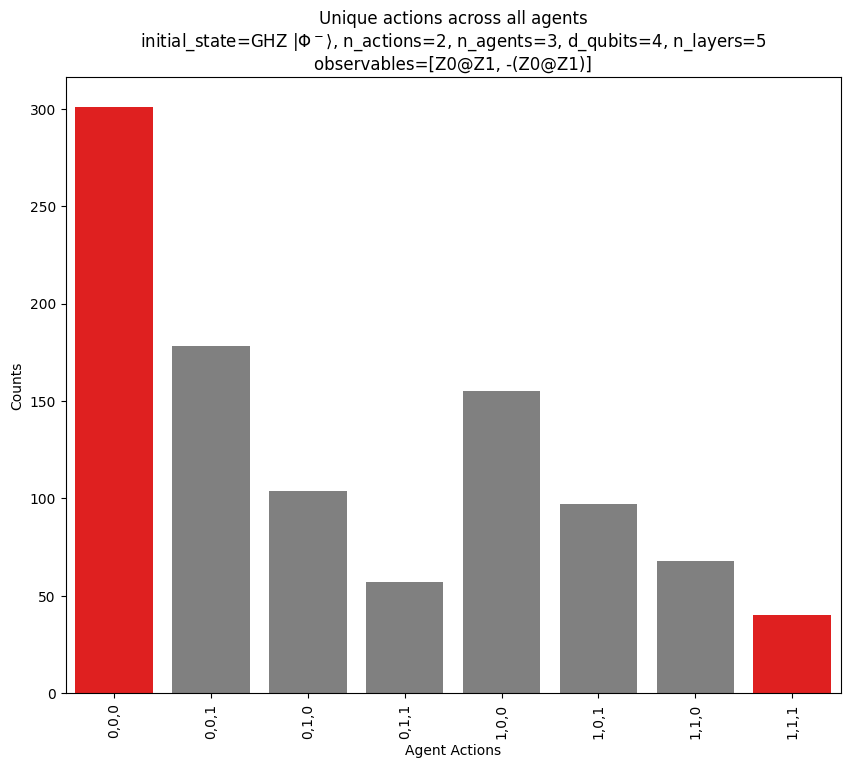

In [40]:
n_actions = 2
n_agents = 3
d_qubits = 4
n_layers = 5
initial_state = lambda wires: entangle_agents_phi_minus(wires=wires, d=d_qubits, n=n_agents)
initial_state_name = 'GHZ $|\Phi^-\\rangle$'
shape_obs = (n_agents, n_actions,)
observables = lambda wires: AlternatingGroupedTensorObservables(
    wires=wires,
    n_groups=n_agents,
    d_qubits=d_qubits,
    n_reps=n_actions,
    ) # [Z0@Z1, -(Z0@Z1), Z2@Z3, -(Z2@Z3), ...] for agents with 2 qubits.
postprocess_func = postprocess_measurements_bipolar_softmax
x = experiment_runner(
    n_agents=n_agents,
    d_qubits=d_qubits,
    n_layers=n_layers,
    shape_obs=shape_obs,
    observables=observables,
    initial_state=initial_state,
    postprocess_func=postprocess_func,
    )
df = measurements_to_df(x, column_key='agent')
title = f"Unique actions across all agents\ninitial_state={initial_state_name}, {n_actions=}, {n_agents=}, {d_qubits=}, {n_layers=}\nobservables={observables_name}"
fig, ax = plot_df(df, title=title, figsize=(10,8))

/Users/derieux/graduate/research/quantum/eqmarl/eqmarl/experiment.py:303: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=keys, y=values, ax=ax, palette=colors)
/Users/derieux/graduate/research/quantum/eqmarl/eqmarl/experiment.py:306: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


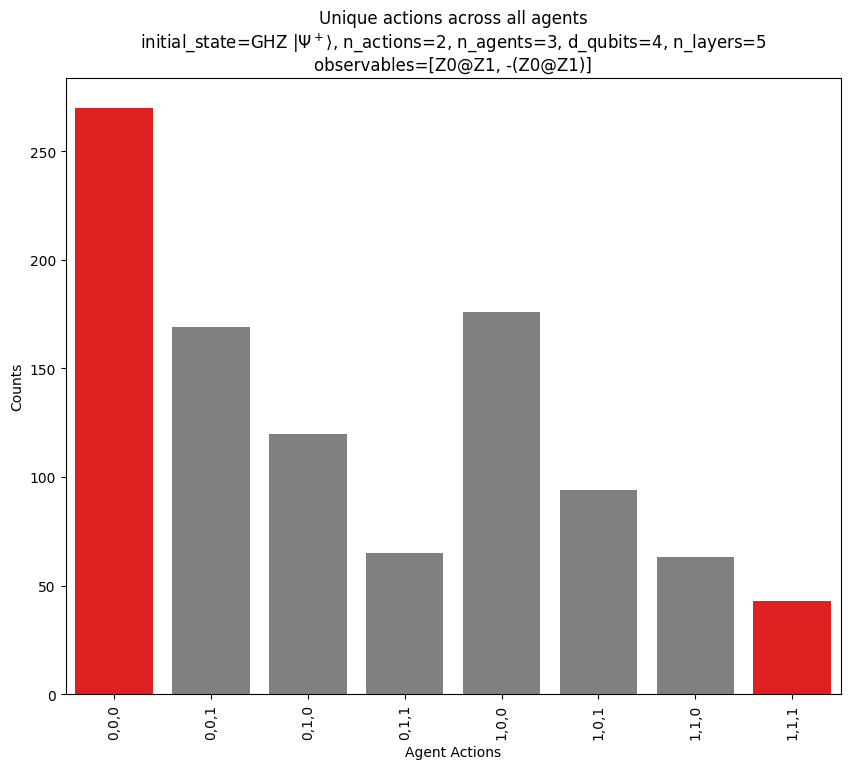

In [41]:
n_actions = 2
n_agents = 3
d_qubits = 4
n_layers = 5
initial_state = lambda wires: entangle_agents_psi_plus(wires=wires, d=d_qubits, n=n_agents)
initial_state_name = 'GHZ $|\Psi^+\\rangle$'
shape_obs = (n_agents, n_actions,)
observables = lambda wires: AlternatingGroupedTensorObservables(
    wires=wires,
    n_groups=n_agents,
    d_qubits=d_qubits,
    n_reps=n_actions,
    ) # [Z0@Z1, -(Z0@Z1), Z2@Z3, -(Z2@Z3), ...] for agents with 2 qubits.
postprocess_func = postprocess_measurements_bipolar_softmax
x = experiment_runner(
    n_agents=n_agents,
    d_qubits=d_qubits,
    n_layers=n_layers,
    shape_obs=shape_obs,
    observables=observables,
    initial_state=initial_state,
    postprocess_func=postprocess_func,
    )
df = measurements_to_df(x, column_key='agent')
title = f"Unique actions across all agents\ninitial_state={initial_state_name}, {n_actions=}, {n_agents=}, {d_qubits=}, {n_layers=}\nobservables={observables_name}"
fig, ax = plot_df(df, title=title, figsize=(10,8))

/Users/derieux/graduate/research/quantum/eqmarl/eqmarl/experiment.py:303: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=keys, y=values, ax=ax, palette=colors)
/Users/derieux/graduate/research/quantum/eqmarl/eqmarl/experiment.py:306: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


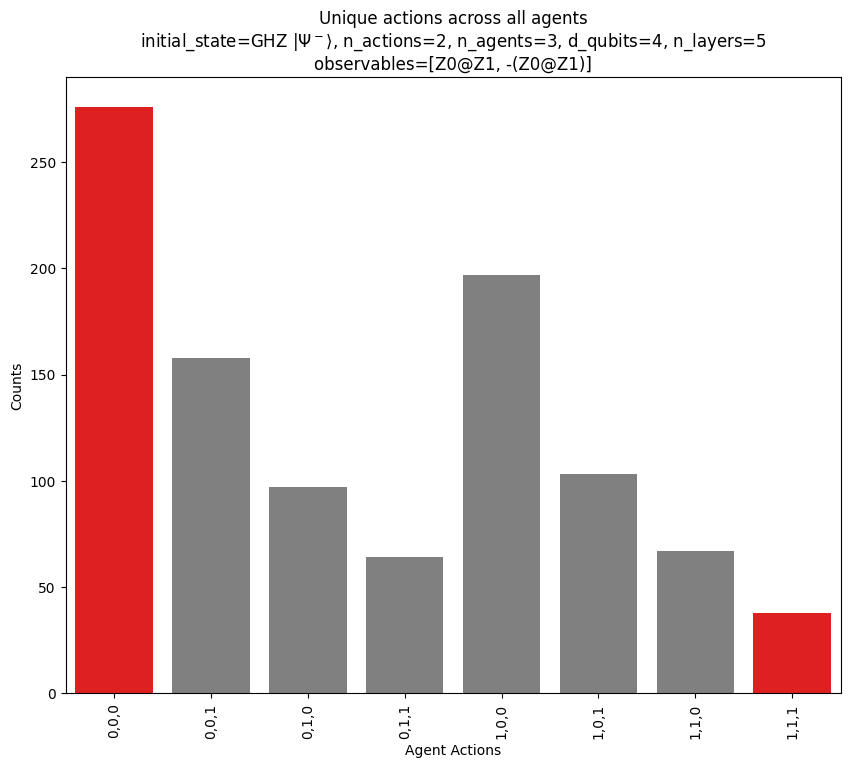

In [42]:

n_actions = 2
n_agents = 3
d_qubits = 4
n_layers = 5
initial_state = lambda wires: entangle_agents_psi_minus(wires=wires, d=d_qubits, n=n_agents)
initial_state_name = 'GHZ $|\Psi^-\\rangle$'
shape_obs = (n_agents, n_actions,)
observables = lambda wires: AlternatingGroupedTensorObservables(
    wires=wires,
    n_groups=n_agents,
    d_qubits=d_qubits,
    n_reps=n_actions,
    ) # [Z0@Z1, -(Z0@Z1), Z2@Z3, -(Z2@Z3), ...] for agents with 2 qubits.
postprocess_func = postprocess_measurements_bipolar_softmax
x = experiment_runner(
    n_agents=n_agents,
    d_qubits=d_qubits,
    n_layers=n_layers,
    shape_obs=shape_obs,
    observables=observables,
    initial_state=initial_state,
    postprocess_func=postprocess_func,
    )
df = measurements_to_df(x, column_key='agent')
title = f"Unique actions across all agents\ninitial_state={initial_state_name}, {n_actions=}, {n_agents=}, {d_qubits=}, {n_layers=}\nobservables={observables_name}"
fig, ax = plot_df(df, title=title, figsize=(10,8))

/Users/derieux/graduate/research/quantum/eqmarl/eqmarl/experiment.py:303: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=keys, y=values, ax=ax, palette=colors)
/Users/derieux/graduate/research/quantum/eqmarl/eqmarl/experiment.py:306: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


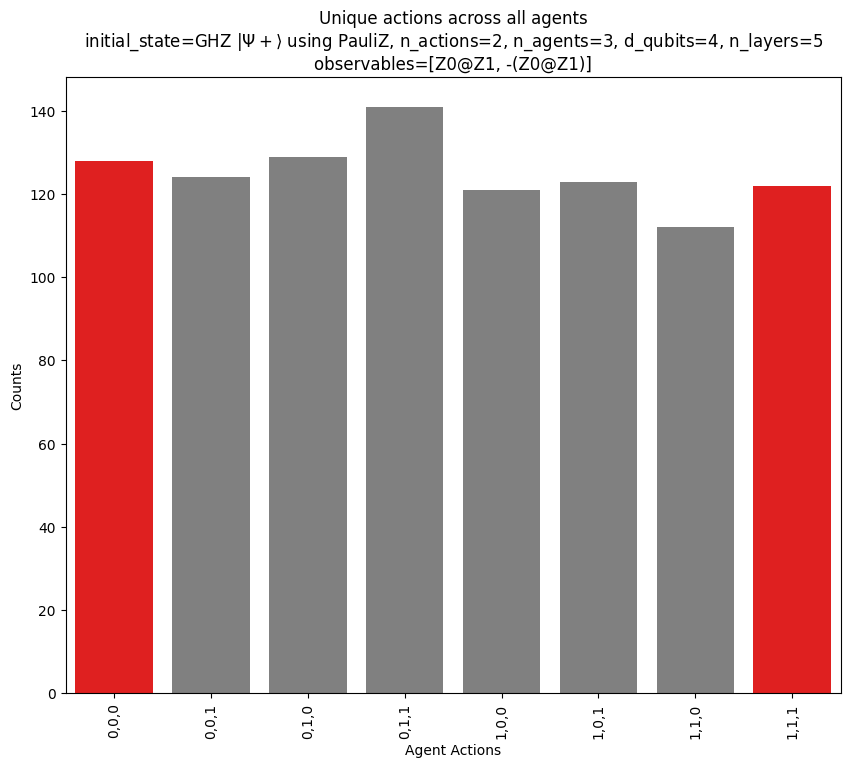

In [43]:
n_actions = 2
n_agents = 3
d_qubits = 4
n_layers = 5
initial_state = lambda wires: entangle_agents_psi_plus(wires=wires, d=d_qubits, n=n_agents, op=qml.CZ)
initial_state_name = 'GHZ $|\Psi+\\rangle$ using PauliZ'
shape_obs = (n_agents, n_actions,)
observables = lambda wires: AlternatingGroupedTensorObservables(
    wires=wires,
    n_groups=n_agents,
    d_qubits=d_qubits,
    n_reps=n_actions,
    ) # [Z0@Z1, -(Z0@Z1), Z2@Z3, -(Z2@Z3), ...] for agents with 2 qubits.
postprocess_func = postprocess_measurements_bipolar_softmax
x = experiment_runner(
    n_agents=n_agents,
    d_qubits=d_qubits,
    n_layers=n_layers,
    shape_obs=shape_obs,
    observables=observables,
    initial_state=initial_state,
    postprocess_func=postprocess_func,
    )
df = measurements_to_df(x, column_key='agent')
title = f"Unique actions across all agents\ninitial_state={initial_state_name}, {n_actions=}, {n_agents=}, {d_qubits=}, {n_layers=}\nobservables={observables_name}"
fig, ax = plot_df(df, title=title, figsize=(10,8))

In [44]:
n_actions = 2
n_agents = 2
d_qubits = 4
n_layers = 5

U, eig_vects, eig_vals = compute_U_eig(
    n_agents=n_agents,
    d_qubits=d_qubits,
    n_layers=n_layers,
)

print(f"{U.shape=}")

U.shape=(256, 256)


/Users/derieux/graduate/research/quantum/eqmarl/eqmarl/experiment.py:303: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=keys, y=values, ax=ax, palette=colors)
/Users/derieux/graduate/research/quantum/eqmarl/eqmarl/experiment.py:306: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


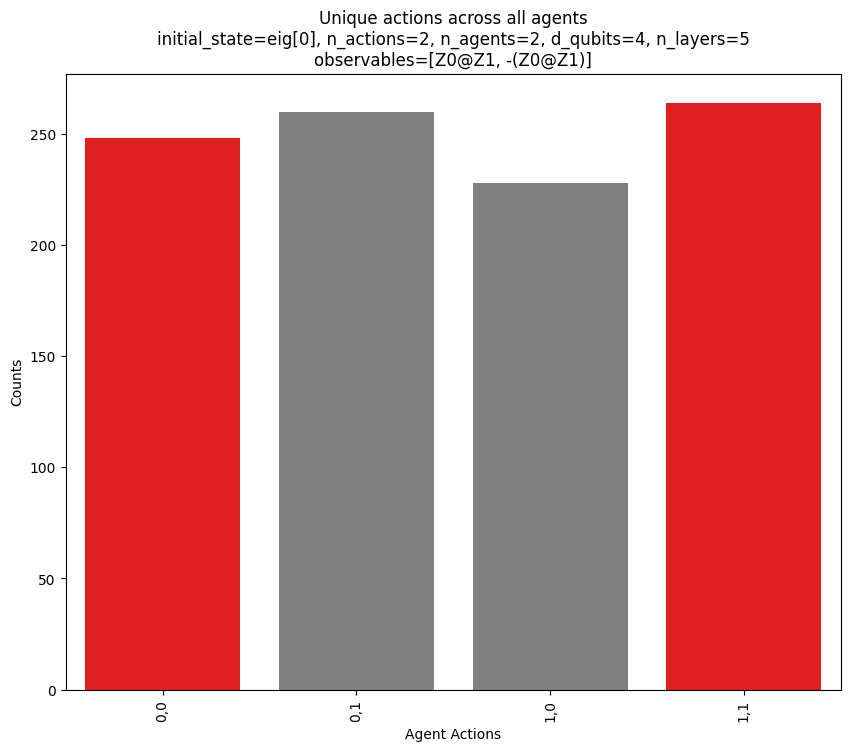

In [45]:
# Create the desired starting state.
# In this case, an equal superposition of the first and last eigenvector.
initial_state = eig_vects[:,0]


n_actions = 2
# initial_state = lambda wires: entangle_agents_phi_plus(wires=wires, d=d_qubits, n=n_agents)
initial_state_name = 'eig[0]'
shape_obs = (n_agents, n_actions,)
observables = lambda wires: AlternatingGroupedTensorObservables(
    wires=wires,
    n_groups=n_agents,
    d_qubits=d_qubits,
    n_reps=n_actions,
    ) # [Z0@Z1, -(Z0@Z1), Z2@Z3, -(Z2@Z3), ...] for agents with 2 qubits.
postprocess_func = postprocess_measurements_bipolar_softmax
x = experiment_runner(
    n_agents=n_agents,
    d_qubits=d_qubits,
    n_layers=n_layers,
    shape_obs=shape_obs,
    observables=observables,
    initial_state=initial_state,
    postprocess_func=postprocess_func,
    )
df = measurements_to_df(x, column_key='agent')
title = f"Unique actions across all agents\ninitial_state={initial_state_name}, {n_actions=}, {n_agents=}, {d_qubits=}, {n_layers=}\nobservables={observables_name}"
fig, ax = plot_df(df, title=title, figsize=(10,8))

/Users/derieux/graduate/research/quantum/eqmarl/eqmarl/experiment.py:303: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=keys, y=values, ax=ax, palette=colors)
/Users/derieux/graduate/research/quantum/eqmarl/eqmarl/experiment.py:306: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


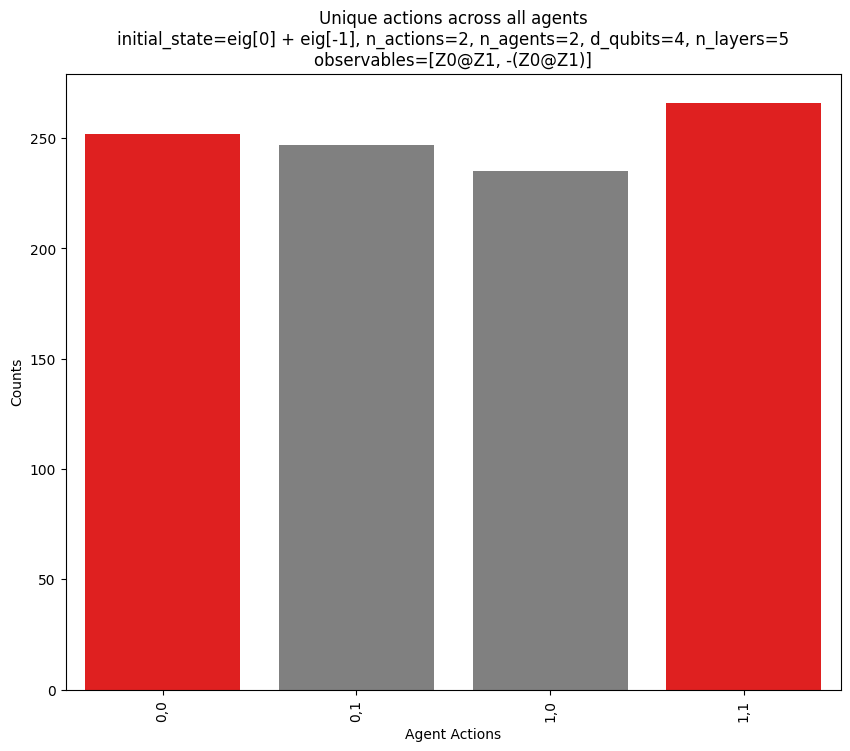

In [46]:
# Create the desired starting state.
# In this case, an equal superposition of the first and last eigenvector.
initial_state = 1/np.sqrt(2) * eig_vects[:,0] + 1/np.sqrt(2) * eig_vects[:,-1]


n_actions = 2
# initial_state = lambda wires: entangle_agents_phi_plus(wires=wires, d=d_qubits, n=n_agents)
initial_state_name = 'eig[0] + eig[-1]'
shape_obs = (n_agents, n_actions,)
observables = lambda wires: AlternatingGroupedTensorObservables(
    wires=wires,
    n_groups=n_agents,
    d_qubits=d_qubits,
    n_reps=n_actions,
    ) # [Z0@Z1, -(Z0@Z1), Z2@Z3, -(Z2@Z3), ...] for agents with 2 qubits.
postprocess_func = postprocess_measurements_bipolar_softmax
x = experiment_runner(
    n_agents=n_agents,
    d_qubits=d_qubits,
    n_layers=n_layers,
    shape_obs=shape_obs,
    observables=observables,
    initial_state=initial_state,
    postprocess_func=postprocess_func,
    )
df = measurements_to_df(x, column_key='agent')
title = f"Unique actions across all agents\ninitial_state={initial_state_name}, {n_actions=}, {n_agents=}, {d_qubits=}, {n_layers=}\nobservables={observables_name}"
fig, ax = plot_df(df, title=title, figsize=(10,8))

/Users/derieux/graduate/research/quantum/eqmarl/eqmarl/experiment.py:303: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=keys, y=values, ax=ax, palette=colors)
/Users/derieux/graduate/research/quantum/eqmarl/eqmarl/experiment.py:306: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


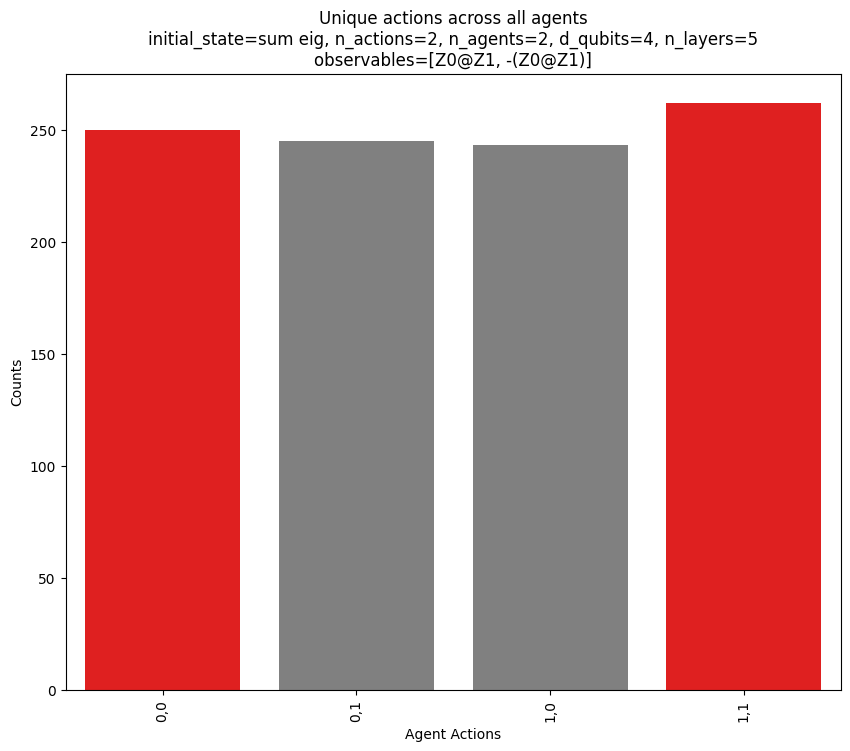

In [47]:
# Create the desired starting state.
# In this case, an equal superposition of all eigenvectors.
initial_state = 1/np.sqrt(eig_vects.shape[-1]) * np.sum(eig_vects, axis=-1) # Add all columns.


n_actions = 2
# initial_state = lambda wires: entangle_agents_phi_plus(wires=wires, d=d_qubits, n=n_agents)
initial_state_name = 'sum eig'
shape_obs = (n_agents, n_actions,)
observables = lambda wires: AlternatingGroupedTensorObservables(
    wires=wires,
    n_groups=n_agents,
    d_qubits=d_qubits,
    n_reps=n_actions,
    ) # [Z0@Z1, -(Z0@Z1), Z2@Z3, -(Z2@Z3), ...] for agents with 2 qubits.
postprocess_func = postprocess_measurements_bipolar_softmax
x = experiment_runner(
    n_agents=n_agents,
    d_qubits=d_qubits,
    n_layers=n_layers,
    shape_obs=shape_obs,
    observables=observables,
    initial_state=initial_state,
    postprocess_func=postprocess_func,
    )
df = measurements_to_df(x, column_key='agent')
title = f"Unique actions across all agents\ninitial_state={initial_state_name}, {n_actions=}, {n_agents=}, {d_qubits=}, {n_layers=}\nobservables={observables_name}"
fig, ax = plot_df(df, title=title, figsize=(10,8))

### Measuring [Z0, Z0@Z1, Z1]

In [48]:
observables_name = "[Z0, Z0@Z1, Z1]"

/Users/derieux/graduate/research/quantum/eqmarl/eqmarl/experiment.py:303: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=keys, y=values, ax=ax, palette=colors)
/Users/derieux/graduate/research/quantum/eqmarl/eqmarl/experiment.py:306: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


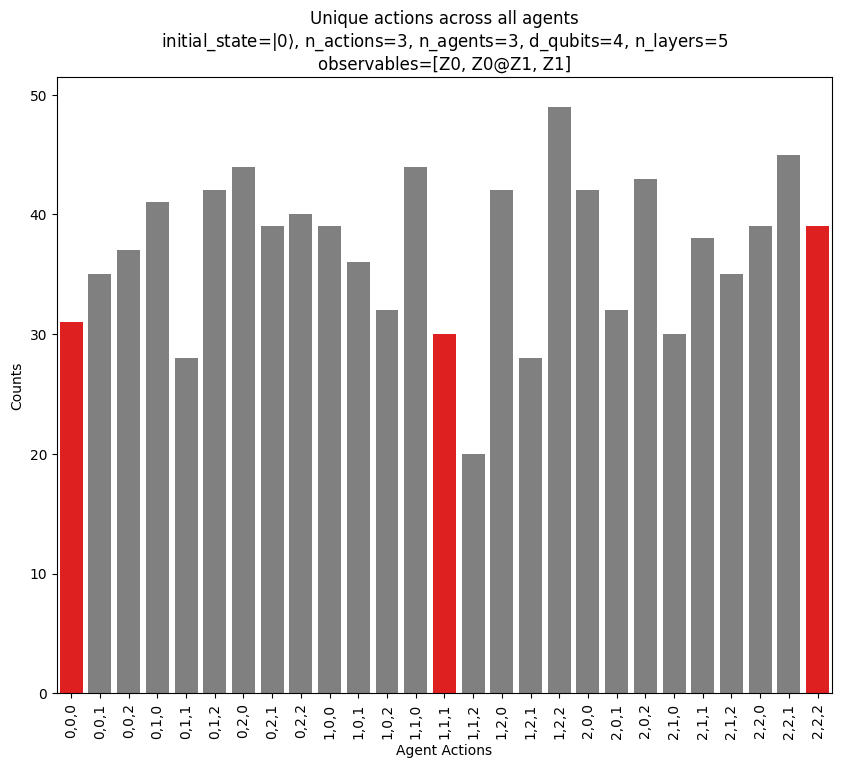

In [49]:
n_actions = 3 # Each agent will have 3 observables.
n_agents = 3
d_qubits = 4
n_layers = 5
initial_state = None
initial_state_name = '$|0\\rangle$'
shape_obs = (n_agents, n_actions,)
observables = lambda wires: GroupedObservables(wires=wires, n_groups=n_agents, d_qubits=d_qubits, func=lambda wires: TensorObservables3(PauliObservables(wires=wires)))
postprocess_func = postprocess_measurements_bipolar_softmax
x = experiment_runner(
    n_agents=n_agents,
    d_qubits=d_qubits,
    n_layers=n_layers,
    shape_obs=shape_obs,
    observables=observables,
    initial_state=initial_state,
    postprocess_func=postprocess_func,
    )
df = measurements_to_df(x, column_key='agent')
title = f"Unique actions across all agents\ninitial_state={initial_state_name}, {n_actions=}, {n_agents=}, {d_qubits=}, {n_layers=}\nobservables={observables_name}"
fig, ax = plot_df(df, title=title, figsize=(10,8))

/Users/derieux/graduate/research/quantum/eqmarl/eqmarl/experiment.py:303: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=keys, y=values, ax=ax, palette=colors)
/Users/derieux/graduate/research/quantum/eqmarl/eqmarl/experiment.py:306: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


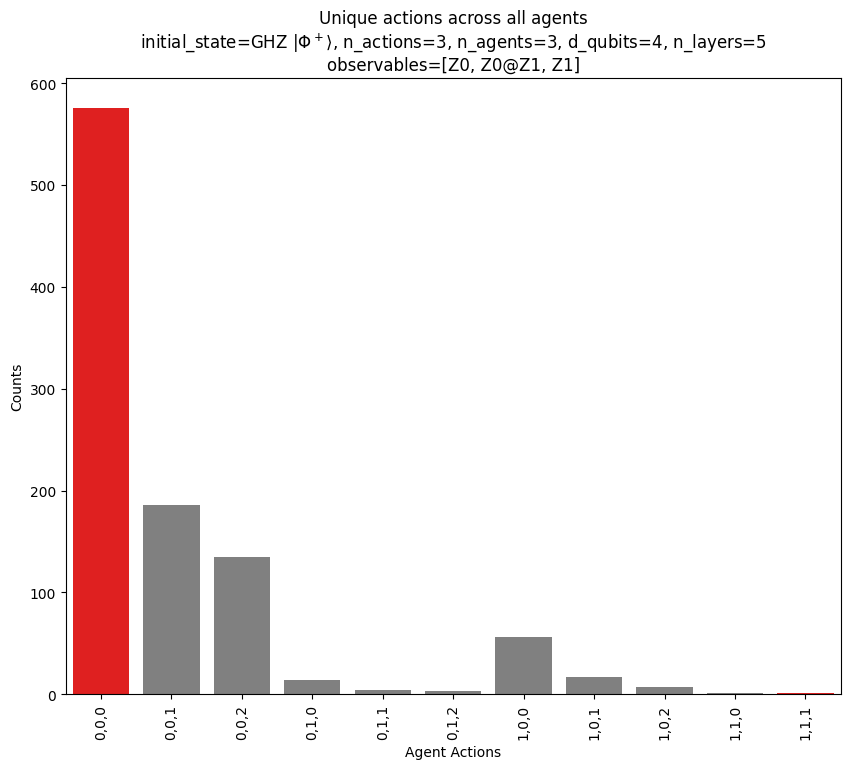

In [50]:
n_actions = 3 # Each agent will have 3 observables.
n_agents = 3
d_qubits = 4
n_layers = 5
initial_state = lambda wires: entangle_agents_phi_plus(wires=wires, d=d_qubits, n=n_agents)
initial_state_name = 'GHZ $|\Phi^+\\rangle$'
shape_obs = (n_agents, n_actions,)
observables = lambda wires: GroupedObservables(wires=wires, n_groups=n_agents, d_qubits=d_qubits, func=lambda wires: TensorObservables3(PauliObservables(wires=wires)))
postprocess_func = postprocess_measurements_bipolar_softmax
x = experiment_runner(
    n_agents=n_agents,
    d_qubits=d_qubits,
    n_layers=n_layers,
    shape_obs=shape_obs,
    observables=observables,
    initial_state=initial_state,
    postprocess_func=postprocess_func,
    )
df = measurements_to_df(x, column_key='agent')
title = f"Unique actions across all agents\ninitial_state={initial_state_name}, {n_actions=}, {n_agents=}, {d_qubits=}, {n_layers=}\nobservables={observables_name}"
fig, ax = plot_df(df, title=title, figsize=(10,8))

/Users/derieux/graduate/research/quantum/eqmarl/eqmarl/experiment.py:303: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=keys, y=values, ax=ax, palette=colors)
/Users/derieux/graduate/research/quantum/eqmarl/eqmarl/experiment.py:306: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


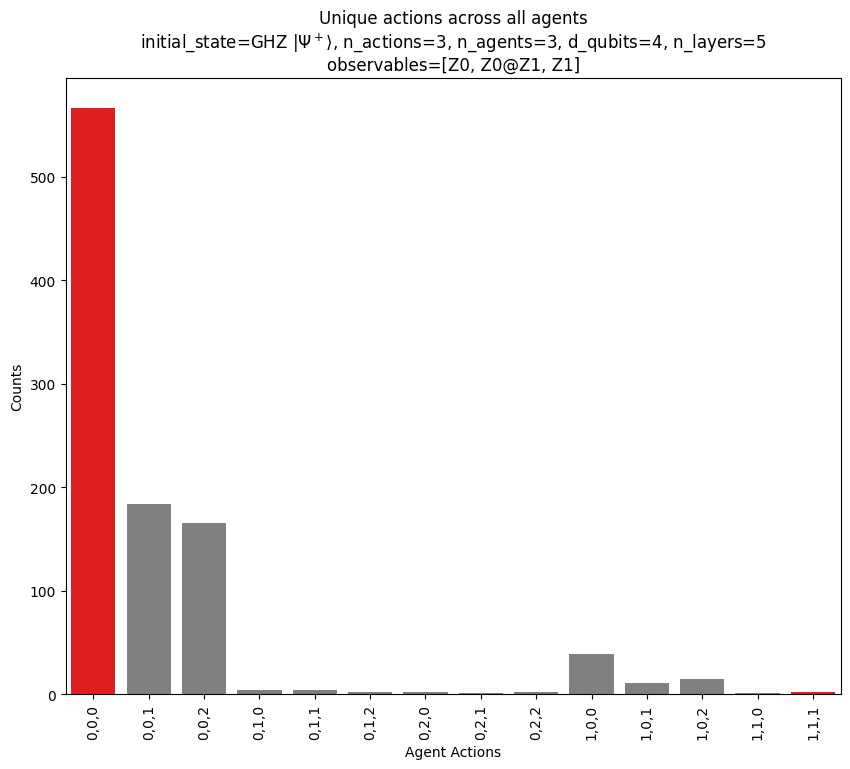

In [51]:

n_actions = 3 # Each agent will have 3 observables.
n_agents = 3
d_qubits = 4
n_layers = 5
initial_state = lambda wires: entangle_agents_psi_plus(wires=wires, d=d_qubits, n=n_agents)
initial_state_name = 'GHZ $|\Psi^+\\rangle$'
shape_obs = (n_agents, n_actions,)
observables = lambda wires: GroupedObservables(wires=wires, n_groups=n_agents, d_qubits=d_qubits, func=lambda wires: TensorObservables3(PauliObservables(wires=wires)))
postprocess_func = postprocess_measurements_bipolar_softmax
x = experiment_runner(
    n_agents=n_agents,
    d_qubits=d_qubits,
    n_layers=n_layers,
    shape_obs=shape_obs,
    observables=observables,
    initial_state=initial_state,
    postprocess_func=postprocess_func,
    )
df = measurements_to_df(x, column_key='agent')
title = f"Unique actions across all agents\ninitial_state={initial_state_name}, {n_actions=}, {n_agents=}, {d_qubits=}, {n_layers=}\nobservables={observables_name}"
fig, ax = plot_df(df, title=title, figsize=(10,8))

### Measuring [Z0, Z1, Z2]

In [52]:
observables_name = "[Z0, Z1, Z2]"

/Users/derieux/graduate/research/quantum/eqmarl/eqmarl/experiment.py:303: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=keys, y=values, ax=ax, palette=colors)
/Users/derieux/graduate/research/quantum/eqmarl/eqmarl/experiment.py:306: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


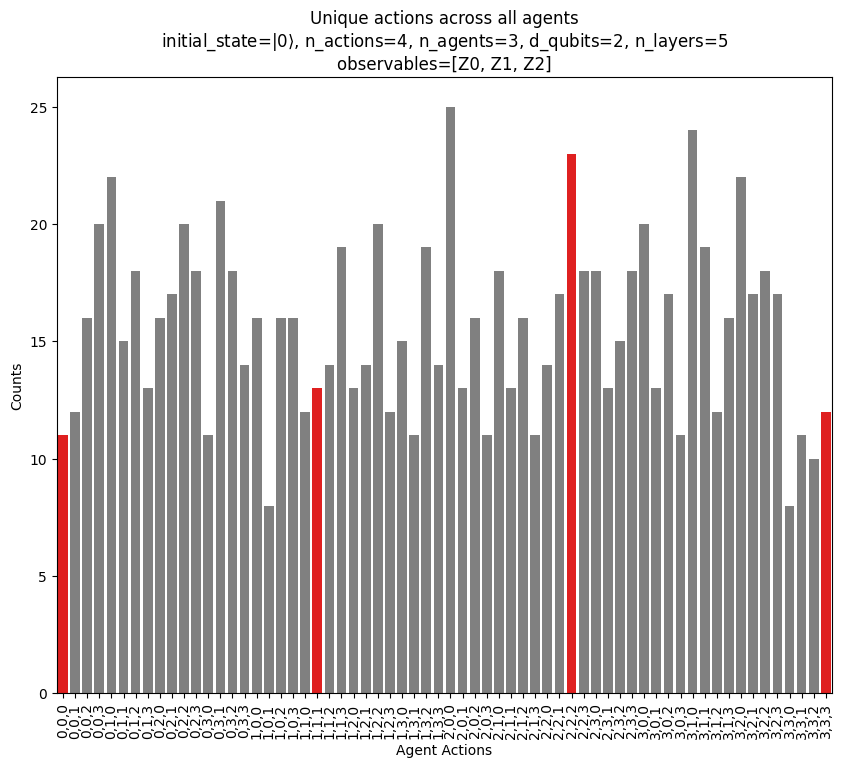

In [53]:
n_agents = 3
d_qubits = 2
n_actions = 2**d_qubits
n_layers = 5
initial_state = None
initial_state_name = '$|0\\rangle$'
shape_obs = (n_agents, d_qubits,)
observables = lambda wires: PauliObservables(wires=wires, op=qml.PauliZ)
postprocess_func = postprocess_measurements_bipolar_integer
x = experiment_runner(
    n_agents=n_agents,
    d_qubits=d_qubits,
    n_layers=n_layers,
    shape_obs=shape_obs,
    observables=observables,
    initial_state=initial_state,
    postprocess_func=postprocess_func,
    )

df = measurements_to_df(x, column_key='agent')
title = f"Unique actions across all agents\ninitial_state={initial_state_name}, {n_actions=}, {n_agents=}, {d_qubits=}, {n_layers=}\nobservables={observables_name}"
fig, ax = plot_df(df, title=title, figsize=(10,8))

/Users/derieux/graduate/research/quantum/eqmarl/eqmarl/experiment.py:303: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=keys, y=values, ax=ax, palette=colors)
/Users/derieux/graduate/research/quantum/eqmarl/eqmarl/experiment.py:306: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


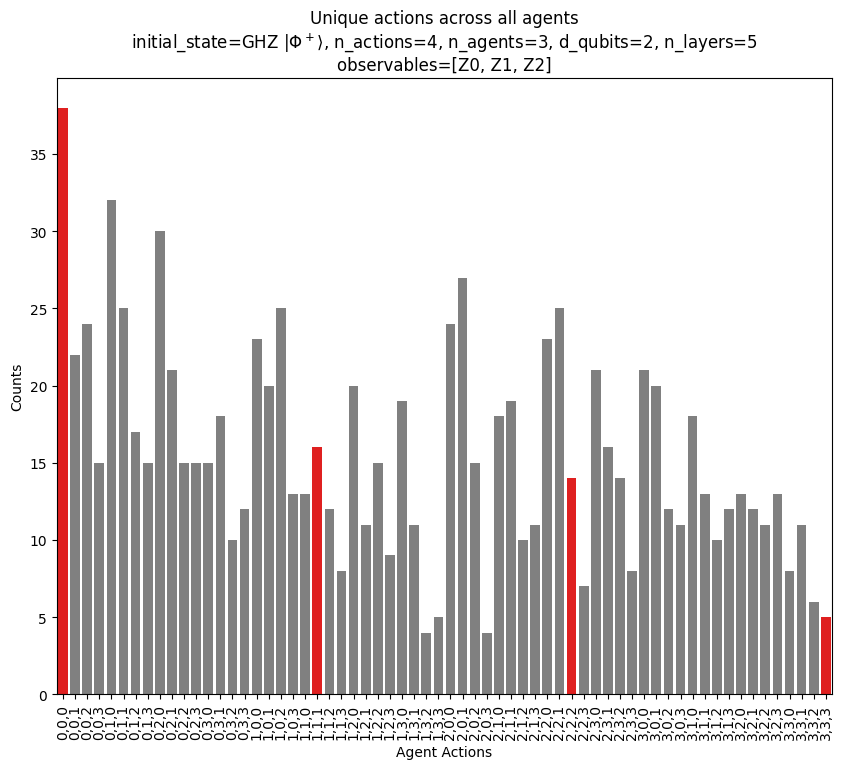

In [54]:
n_agents = 3
d_qubits = 2
n_actions = 2**d_qubits
n_layers = 5
initial_state = lambda wires: entangle_agents_phi_plus(wires=wires, d=d_qubits, n=n_agents)
initial_state_name = 'GHZ $|\Phi^+\\rangle$'
shape_obs = (n_agents, d_qubits,)
observables = lambda wires: PauliObservables(wires=wires, op=qml.PauliZ)
postprocess_func = postprocess_measurements_bipolar_integer
x = experiment_runner(
    n_agents=n_agents,
    d_qubits=d_qubits,
    n_layers=n_layers,
    shape_obs=shape_obs,
    observables=observables,
    initial_state=initial_state,
    postprocess_func=postprocess_func,
    )

df = measurements_to_df(x, column_key='agent')
title = f"Unique actions across all agents\ninitial_state={initial_state_name}, {n_actions=}, {n_agents=}, {d_qubits=}, {n_layers=}\nobservables={observables_name}"
fig, ax = plot_df(df, title=title, figsize=(10,8))

/Users/derieux/graduate/research/quantum/eqmarl/eqmarl/experiment.py:303: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=keys, y=values, ax=ax, palette=colors)
/Users/derieux/graduate/research/quantum/eqmarl/eqmarl/experiment.py:306: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


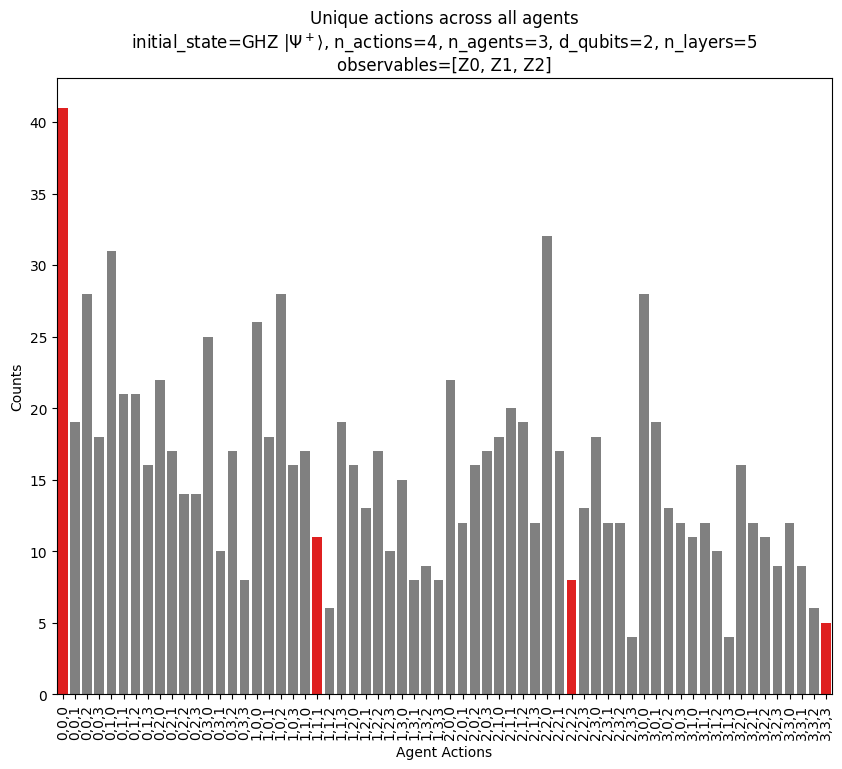

In [55]:
n_agents = 3
d_qubits = 2
n_actions = 2**d_qubits
n_layers = 5
initial_state = lambda wires: entangle_agents_psi_plus(wires=wires, d=d_qubits, n=n_agents)
initial_state_name = 'GHZ $|\Psi^+\\rangle$'
shape_obs = (n_agents, d_qubits,)
observables = lambda wires: PauliObservables(wires=wires, op=qml.PauliZ)
postprocess_func = postprocess_measurements_bipolar_integer
x = experiment_runner(
    n_agents=n_agents,
    d_qubits=d_qubits,
    n_layers=n_layers,
    shape_obs=shape_obs,
    observables=observables,
    initial_state=initial_state,
    postprocess_func=postprocess_func,
    )

df = measurements_to_df(x, column_key='agent')
title = f"Unique actions across all agents\ninitial_state={initial_state_name}, {n_actions=}, {n_agents=}, {d_qubits=}, {n_layers=}\nobservables={observables_name}"
fig, ax = plot_df(df, title=title, figsize=(10,8))

-------

## Other Things

In [18]:
count_dict = df.value_counts().to_dict()
vals = [count_dict[key] for key in [(0, 0, 0), (1, 1, 1), (2, 2, 2)]]
vals, sum(vals)

([41, 53, 41], 135)

In [3]:
# Check shapes of variational+encoding PQC parameters.
wires = list(range(4))
shape_var, shape_enc = VariationalEncodingPQC.shape(n_layers=1, wires=wires)
shape_var, shape_enc

((2, 4, 3), (1, 4, 1))

In [5]:

wires = list(range(4))

batch_size = 16
n_layers = 3
observables = lambda wires: AlternatingWeightedObservables(TensorObservables(PauliObservables(wires=wires)), n_reps=2) # Creates alternating Pauli tensor product observables.
circuit = AgentCircuit(wires=wires, n_layers=n_layers, observables=observables)

# dev = qml.device('default.qubit', wires=wires)
# qnode = qml.QNode(func=circuit, device=dev)
qnode = circuit.qnode(device='default.qubit')
# qnode = circuit.qnode(device=dev)

# Assign random circuit parameters.
shape_var, shape_enc = circuit.shape
weights_var = np.random.uniform(low=0., high=np.pi, size=(batch_size, *shape_var,))
weights_enc = np.random.uniform(low=0., high=np.pi, size=(batch_size, *shape_enc,))

print(qml.draw(qnode, wire_order=wires)(weights_var, weights_enc))

res = qnode(weights_var, weights_enc) # Shape is (n_observables, batch)
res = np.asarray(res).T # Reshape to (batch, n_observables)

0: ─╭VariationalEncodingPQC─┤ ╭<𝓗(1.00)> ╭<𝓗(-1.00)>
1: ─├VariationalEncodingPQC─┤ ├<𝓗(1.00)> ├<𝓗(-1.00)>
2: ─├VariationalEncodingPQC─┤ ├<𝓗(1.00)> ├<𝓗(-1.00)>
3: ─╰VariationalEncodingPQC─┤ ╰<𝓗(1.00)> ╰<𝓗(-1.00)>


(<Figure size 3000x500 with 1 Axes>, <Axes: >)

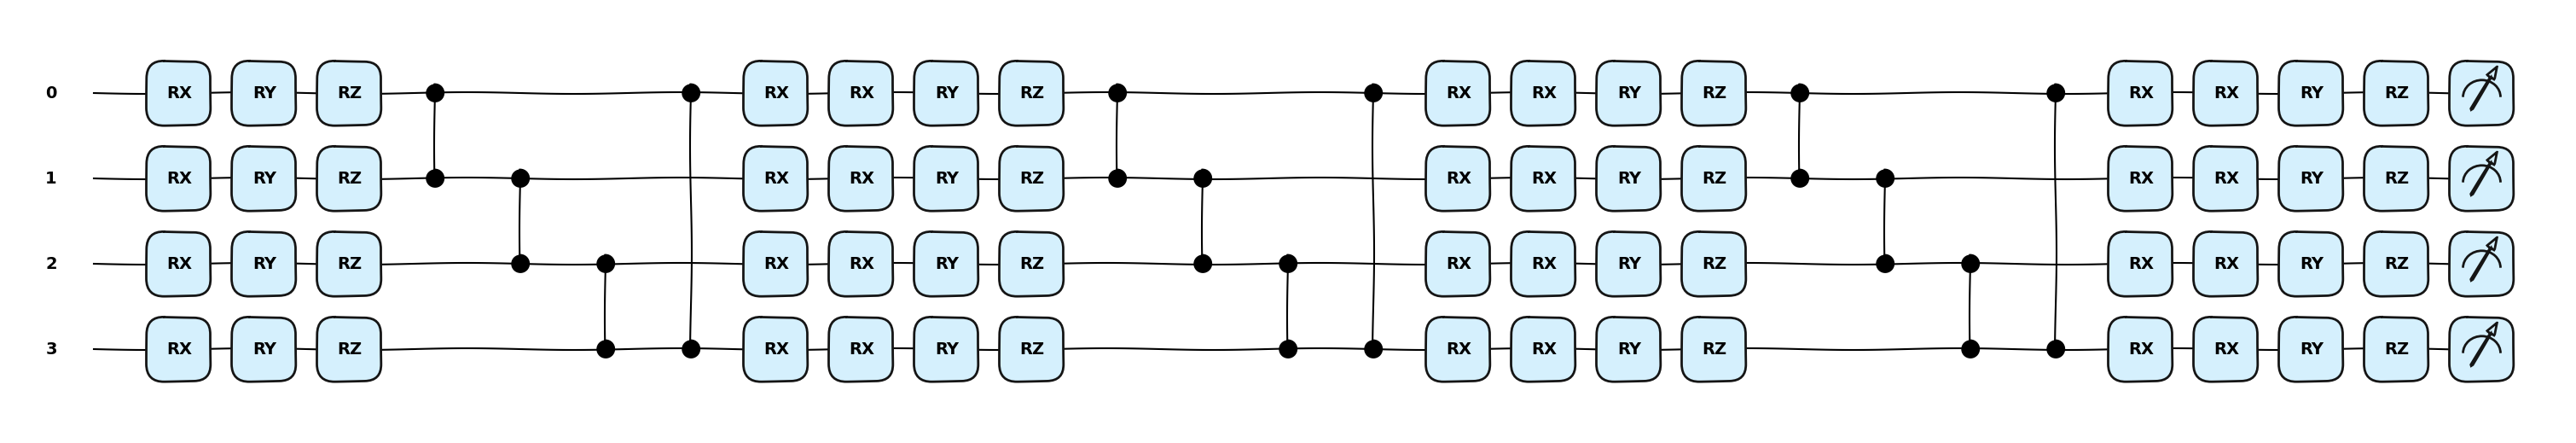

In [6]:
qml.draw_mpl(qnode, wire_order=wires, style="pennylane", decimals=2, expansion_strategy='device')(weights_var, weights_enc)

In [7]:
shape_var, shape_enc = circuit.shape
wires = circuit.wires

weight_shapes = {
    'weights_var': shape_var,
    'weights_enc': shape_enc,
}
qlayer = qml.qnn.KerasLayer(qnode=qnode, weight_shapes=weight_shapes, output_dim=circuit.output_shape)
qlayer

# inp = keras.Input(shape=circuit.input_shape)
inp = keras.Input(shape=circuit.input_shape)
model = keras.Sequential([
    inp,
    qlayer,
    keras.layers.Softmax(),
    ])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2)                 60        
                                                                 
 softmax (Softmax)           (None, 2)                 0         
                                                                 
Total params: 60 (240.00 Byte)
Trainable params: 60 (240.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
inputs = np.random.uniform(low=0., high=np.pi, size=(16, *circuit.input_shape))
# inputs = np.random.uniform(low=0., high=np.pi, size=circuit.input_shape)
res = model(inputs)

inputs.shape, res.shape

/usr/local/Caskroom/miniforge/base/envs/qml/lib/python3.11/site-packages/pennylane/math/utils.py:227: UserWarning: Contains tensors of types {'tensorflow', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


((16, 4), TensorShape([16, 2]))

In [ ]:
AlternatingGroupedTensorObservables(wires=list(range(4)), n_groups=2, d_qubits=2, n_reps=2)

array([<Hamiltonian: terms=1, wires=[0, 1]>,
       <Hamiltonian: terms=1, wires=[0, 1]>,
       <Hamiltonian: terms=1, wires=[2, 3]>,
       <Hamiltonian: terms=1, wires=[2, 3]>], dtype=object)

In [ ]:


n_layers = 3
n_agents = 3
d_qubits = 3


observables = lambda wires: AlternatingGroupedTensorObservables(wires=wires, n_groups=n_agents, d_qubits=d_qubits, n_reps=2)
circuit = MARLCircuit(
    n_agents=n_agents,
    d_qubits=d_qubits,
    n_layers=n_layers,
    observables=observables,
    initial_state=None,
    )
wires = circuit.wires

# dev = qml.device('default.qubit', wires=wires)
# qnode = qml.QNode(func=circuit, device=dev)
qnode = circuit.qnode(device='default.qubit')

# Assign random circuit parameters.
batch_size = 16
shape_var, shape_enc = circuit.shape
weights_var = np.random.uniform(low=0., high=np.pi, size=(batch_size, *shape_var,))
weights_enc = np.random.uniform(low=0., high=np.pi, size=(batch_size, *shape_enc,))

print(qml.draw(qnode, wire_order=wires)(weights_var, weights_enc))

# Evaluate circuit.
res = qnode(weights_var, weights_enc) # Shape is (n_agents * n_observables, batch)
res = np.asarray(res)
# res = np.asarray(res).T.reshape((-1, n_agents, 2)) # Reshape to (batch, n_agents, n_observables)
res.shape

0: ─╭VariationalEncodingPQC─┤ ╭<𝓗(1.00)> ╭<𝓗(-1.00)>
1: ─├VariationalEncodingPQC─┤ ├<𝓗(1.00)> ├<𝓗(-1.00)>
2: ─╰VariationalEncodingPQC─┤ ╰<𝓗(1.00)> ╰<𝓗(-1.00)>
3: ─╭VariationalEncodingPQC─┤ ╭<𝓗(1.00)> ╭<𝓗(-1.00)>
4: ─├VariationalEncodingPQC─┤ ├<𝓗(1.00)> ├<𝓗(-1.00)>
5: ─╰VariationalEncodingPQC─┤ ╰<𝓗(1.00)> ╰<𝓗(-1.00)>
6: ─╭VariationalEncodingPQC─┤ ╭<𝓗(1.00)> ╭<𝓗(-1.00)>
7: ─├VariationalEncodingPQC─┤ ├<𝓗(1.00)> ├<𝓗(-1.00)>
8: ─╰VariationalEncodingPQC─┤ ╰<𝓗(1.00)> ╰<𝓗(-1.00)>


(6, 16)

(<Figure size 2700x1000 with 1 Axes>, <Axes: >)

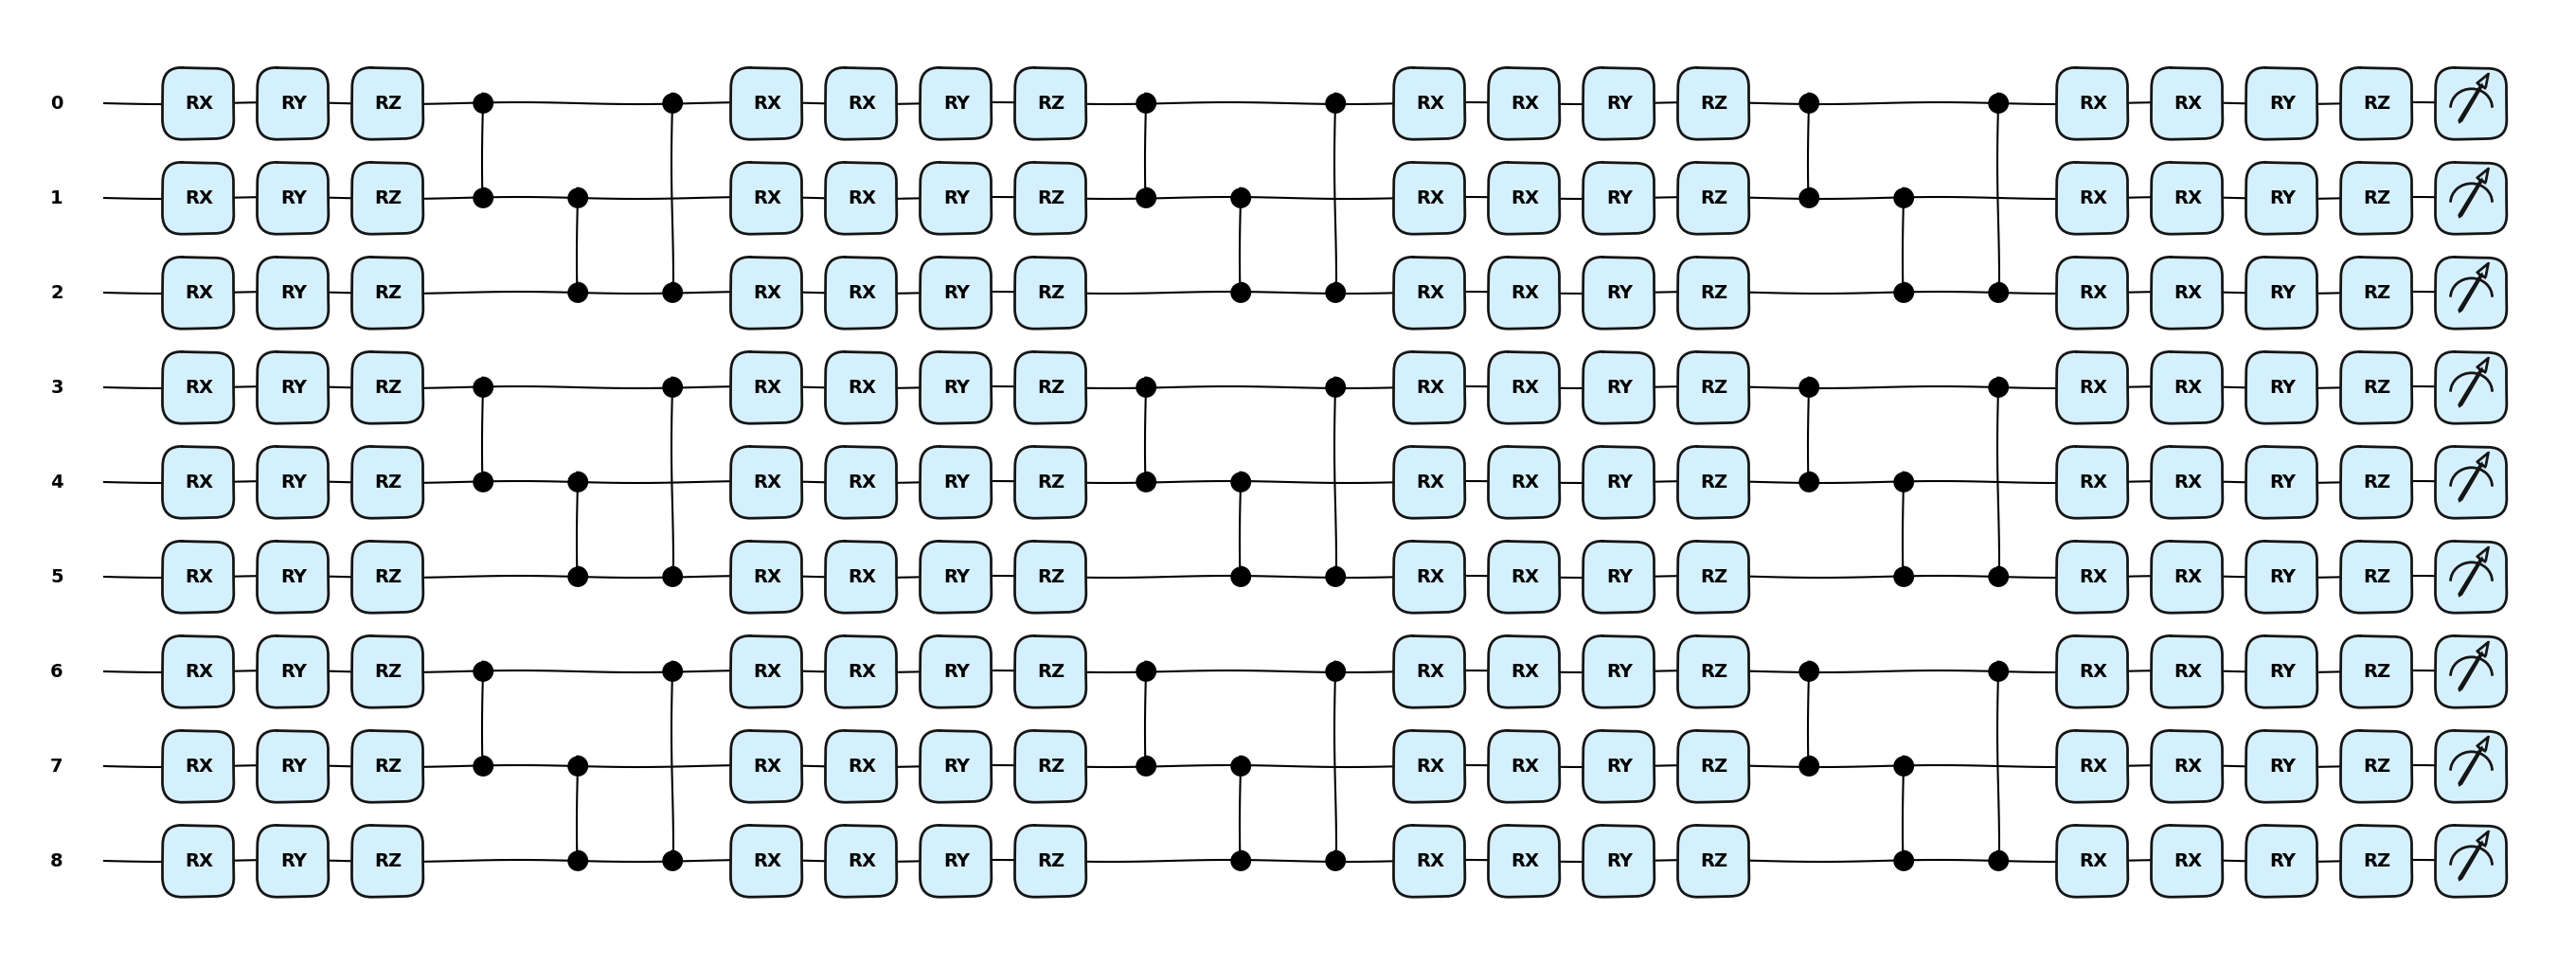

In [ ]:
qml.draw_mpl(qnode, wire_order=wires, style="pennylane", decimals=2, expansion_strategy='device')(weights_var, weights_enc)

In [ ]:
def softmax(x, axis=None):
    x = x - np.max(x, axis=axis, keepdims=True)
    y = np.exp(x)
    return y / np.sum(y, axis=axis, keepdims=True)

In [ ]:
shape_var, shape_enc = circuit.shape
wires = circuit.wires

weight_shapes = {
    'agents_var_thetas': shape_var,
    'agents_enc_inputs': shape_enc,
}
qlayer = qml.qnn.KerasLayer(qnode=qnode, weight_shapes=weight_shapes, output_dim=circuit.output_shape)
qlayer

# inp = keras.Input(shape=circuit.input_shape)
inp = keras.Input(shape=circuit.input_shape)
model = keras.Sequential([
    inp,
    qlayer,
    keras.layers.Reshape(target_shape=(n_agents, 2)), # Using `TensorPauliZ` as observables, so shape has 2 features because we use +1/-1 eigenvalues to represent binary actions.
    keras.layers.Softmax(),
    ])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 6)                 135       
                                                                 
 reshape (Reshape)           (None, 3, 2)              0         
                                                                 
 softmax_1 (Softmax)         (None, 3, 2)              0         
                                                                 
Total params: 135 (540.00 Byte)
Trainable params: 135 (540.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
inputs = np.random.uniform(low=0., high=np.pi, size=(4, *circuit.input_shape))
# inputs = np.random.uniform(low=0., high=np.pi, size=circuit.input_shape)
res = model(inputs)

inputs.shape, res.shape

/usr/local/Caskroom/miniforge/base/envs/qml/lib/python3.11/site-packages/pennylane/math/utils.py:227: UserWarning: Contains tensors of types {'autograd', 'tensorflow'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


((4, 9), TensorShape([4, 3, 2]))

In [14]:
res[0]

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[0.45386913, 0.5461309 ],
       [0.50923735, 0.49076265],
       [0.76063716, 0.23936282]], dtype=float32)>

In [15]:
res[0], tf.math.argmax(res, axis=-1)[0]

(<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
 array([[0.45386913, 0.5461309 ],
        [0.50923735, 0.49076265],
        [0.76063716, 0.23936282]], dtype=float32)>,
 <tf.Tensor: shape=(3,), dtype=int64, numpy=array([1, 0, 0])>)

In [16]:
agents_var_thetas = np.random.uniform(low=0., high=np.pi, size=shape_var)
agents_enc_inputs = np.random.uniform(low=0., high=np.pi, size=shape_enc)

In [17]:
# Compute matrix representation for entire circuit.
if len(agents_var_thetas.shape) == 5: # batched
    U = np.asarray(qml.matrix(qnode, wire_order=wires)(agents_var_thetas[0], agents_enc_inputs[0]))
else: # Not batched.
    U = np.asarray(qml.matrix(qnode, wire_order=wires)(agents_var_thetas, agents_enc_inputs))

U.shape # for 8 qubits is (256, 256)

(512, 512)

In [18]:
eig_vals, eig_vects = cirq.unitary_eig(U) # eig_vects is a matrix with eigenvectors as columns.
eig_vects.shape

(512, 512)

In [19]:
initial_state = 1/np.sqrt(2) * eig_vects[:,0] + 1/np.sqrt(2) * eig_vects[:,-1]
initial_state

array([-2.76174074e-02+2.88411780e-02j, -3.15545043e-02+1.54803002e-03j,
        2.07391757e-02+1.03175951e-02j,  5.75486025e-02-1.62083163e-02j,
        4.68526834e-04-3.64975524e-02j, -2.78990077e-05-3.08726141e-03j,
       -6.44796235e-03+4.07341086e-02j,  1.38763669e-02+4.99033362e-02j,
        9.77572181e-03-3.03856394e-02j, -2.49320270e-02-3.82657263e-02j,
       -1.98451112e-02+2.42275190e-02j, -4.56298720e-02+4.88091139e-02j,
        7.21505349e-06+4.33902968e-02j,  8.36399372e-03-2.15766546e-02j,
       -2.45912797e-02+2.70092246e-03j, -4.54315547e-02-2.86626544e-02j,
        5.03495410e-02-3.34843130e-02j,  3.63489022e-03+5.80756959e-02j,
        1.77351578e-03-1.42467836e-02j, -7.24413636e-02+2.12249972e-02j,
        4.48738414e-03+7.30649854e-02j, -2.77294025e-02-1.02707241e-02j,
        6.03414815e-02-3.12418989e-02j, -5.77771369e-03-5.60529549e-02j,
       -4.19947240e-03-1.64708834e-02j, -2.23849900e-02-8.24054794e-02j,
       -3.15035266e-02+3.09895664e-02j, -3.31992513

In [20]:
def experiment(n, d, n_layers, initial_state, n_runs=100, batch_size=16):

    circuit = MARLCircuit(
        n=n,
        d=d,
        n_layers=n_layers,
        initial_state=initial_state,
        )
    wires = circuit.wires

    dev = qml.device('default.qubit', wires=wires)
    qnode = qml.QNode(func=circuit, device=dev)
    
    shape_var, shape_enc = circuit.shape
    
    # Divide runs into batched chunks.
    history = []
    for i in range(0, n_runs, batch_size):
        # Ensure chunk size never causes total number of runs to exceed maximum.
        chunk_size = min(n_runs - i, batch_size)
        
        tmp_agents_var_thetas = np.random.uniform(low=0., high=np.pi, size=(chunk_size, *shape_var))
        tmp_agents_enc_inputs = np.random.uniform(low=0., high=np.pi, size=(chunk_size, *shape_enc))
        meas = qnode(
            agents_var_thetas=tmp_agents_var_thetas,
            agents_enc_inputs=tmp_agents_enc_inputs,
        )
        meas = np.asarray(meas).T # Reshape so batch dimension is first.
        meas = meas.reshape((-1, n, 2)) # Reshape to 3D with (batches, n_agents, 2)

        res = softmax(meas, axis=-1)
        res = np.argmax(res, axis=-1)
        history.extend(res)

    # Determine how many times each row of actions occurred.
    return np.unique(np.asarray(history), axis=0, return_counts=True)

In [21]:
# Initial state is all zeros (default |0>).
initial_state = None

experiment(
    n=n_agents,
    d=d_qubits,
    n_layers=n_layers,
    initial_state=initial_state,
    n_runs=100,
    )

(array([[0, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 1],
        [1, 0, 0],
        [1, 0, 1],
        [1, 1, 0],
        [1, 1, 1]]),
 array([13, 12, 17, 15, 13, 10, 10, 10]))

In [22]:
# Create the desired starting state.
# In this case, an equal superposition of the first and last eigenvector.
initial_state = 1/np.sqrt(2) * eig_vects[:,0] + 1/np.sqrt(2) * eig_vects[:,-1]

experiment(
    n=n_agents,
    d=d_qubits,
    n_layers=n_layers,
    initial_state=initial_state,
    n_runs=1000,
    batch_size=32
    )

(array([[0, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 1],
        [1, 0, 0],
        [1, 0, 1],
        [1, 1, 0],
        [1, 1, 1]]),
 array([145, 123, 123, 107, 120, 133, 136, 113]))

In [23]:
# Create the desired starting state.
# In this case, an equal superposition of all eigenvectors.
initial_state = 1/np.sqrt(eig_vects.shape[-1]) * np.sum(eig_vects, axis=-1) # Add all columns.

experiment(
    n=n_agents,
    d=d_qubits,
    n_layers=n_layers,
    initial_state=initial_state,
    n_runs=1000,
    batch_size=32
    )

(array([[0, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 1],
        [1, 0, 0],
        [1, 0, 1],
        [1, 1, 0],
        [1, 1, 1]]),
 array([111, 134, 122, 111, 131, 136, 124, 131]))

In [24]:
# Create the desired starting state.
# In this case, an equal superposition of all eigenvectors.
initial_state = lambda wires: entangle_agents_phi_plus(wires=wires, d=d_qubits, n=n_agents)

experiment(
    n=n_agents,
    d=d_qubits,
    n_layers=n_layers,
    initial_state=initial_state,
    n_runs=1000,
    batch_size=32
    )

(array([[0, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 1],
        [1, 0, 0],
        [1, 0, 1],
        [1, 1, 0],
        [1, 1, 1]]),
 array([349, 184, 133,  78, 129,  59,  45,  23]))

In [25]:
# Create the desired starting state.
# In this case, an equal superposition of all eigenvectors.
initial_state = 'phi-'

experiment(
    n=n_agents,
    d=d_qubits,
    n_layers=n_layers,
    initial_state=initial_state,
    n_runs=1000,
    batch_size=32
    )

(array([[0, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 1],
        [1, 0, 0],
        [1, 0, 1],
        [1, 1, 0],
        [1, 1, 1]]),
 array([360, 191, 125,  58, 129,  72,  45,  20]))

In [26]:
# Create the desired starting state.
# In this case, an equal superposition of all eigenvectors.
initial_state = 'psi+'

experiment(
    n=n_agents,
    d=d_qubits,
    n_layers=n_layers,
    initial_state=initial_state,
    n_runs=1000,
    batch_size=32
    )

(array([[0, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 1],
        [1, 0, 0],
        [1, 0, 1],
        [1, 1, 0],
        [1, 1, 1]]),
 array([365, 173, 137,  66, 129,  59,  44,  27]))

In [27]:
# Create the desired starting state.
# In this case, an equal superposition of all eigenvectors.
initial_state = 'psi-'

experiment(
    n=n_agents,
    d=d_qubits,
    n_layers=n_layers,
    initial_state=initial_state,
    n_runs=1000,
    batch_size=32
    )

(array([[0, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 1],
        [1, 0, 0],
        [1, 0, 1],
        [1, 1, 0],
        [1, 1, 1]]),
 array([380, 187, 124,  61, 135,  55,  39,  19]))

In [28]:
# def experiment_IndividualPauliZ(qnode, d, n, n_layers, initial_state, n_runs=100, batch_size=16):
def experiment_IndividualPauliZ(n, d, n_layers, initial_state, n_runs=100, batch_size=16):
    
    circuit = MARLCircuit(
        n=n,
        d=d,
        n_layers=n_layers,
        initial_state=initial_state,
        obs_func=IndividualPauliZ,
        )
    wires = circuit.wires

    dev = qml.device('default.qubit', wires=wires)
    qnode = qml.QNode(func=circuit, device=dev)
    
    shape_var, shape_enc = circuit.shape
    
    # Divide runs into batched chunks.
    history = []
    for i in range(0, n_runs, batch_size):
        # Ensure chunk size never causes total number of runs to exceed maximum.
        chunk_size = min(n_runs - i, batch_size)
        tmp_agents_var_thetas = np.random.uniform(low=0., high=np.pi, size=(chunk_size, *shape_var))
        tmp_agents_enc_inputs = np.random.uniform(low=0., high=np.pi, size=(chunk_size, *shape_enc))
        # meas = qnode(wires, d, n, n_layers, tmp_agents_var_thetas, tmp_agents_enc_inputs, initial_state, obs_func=IndividualPauliZ)
        meas = qnode(
            agents_var_thetas=tmp_agents_var_thetas,
            agents_enc_inputs=tmp_agents_enc_inputs,
        )
        meas = np.asarray(meas).T # Reshape so batch dimension is first.
        meas = meas.reshape((-1, n, d)) # Reshape to 3D with (batches, n_agents, d_qubits)
        
        history.extend(np.asarray(meas >= 0, dtype=int))

    # Determine how many times each row of actions occurred.
    return np.unique(np.asarray(history), axis=0, return_counts=True)

In [29]:
initial_state = None

# states, counts = experiment_IndividualPauliZ(qnode, d, n, n_layers, initial_state, n_runs=1000, batch_size=32)

states, counts = experiment_IndividualPauliZ(
    n=n_agents,
    d=d_qubits,
    n_layers=n_layers,
    initial_state=initial_state,
    n_runs=1000,
    batch_size=32
    )

states, counts

(array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 1]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 1, 1]],
 
        ...,
 
        [[1, 1, 1],
         [1, 1, 1],
         [1, 0, 1]],
 
        [[1, 1, 1],
         [1, 1, 1],
         [1, 1, 0]],
 
        [[1, 1, 1],
         [1, 1, 1],
         [1, 1, 1]]]),
 array([1, 2, 3, 1, 3, 4, 1, 2, 2, 1, 4, 2, 1, 2, 3, 1, 3, 2, 1, 3, 3, 2,
        2, 1, 3, 2, 2, 1, 2, 6, 4, 2, 2, 4, 2, 3, 4, 4, 1, 5, 1, 2, 2, 1,
        1, 5, 1, 3, 3, 1, 4, 1, 1, 2, 2, 3, 3, 4, 2, 2, 1, 2, 3, 2, 3, 2,
        1, 1, 1, 2, 2, 2, 2, 2, 3, 1, 2, 2, 2, 2, 2, 2, 3, 1, 2, 1, 4, 2,
        2, 2, 2, 4, 3, 2, 2, 2, 3, 1, 1, 1, 3, 1, 4, 7, 1, 3, 1, 2, 3, 3,
        5, 3, 3, 1, 3, 1, 4, 3, 1, 1, 1, 2, 2, 2, 6, 5, 1, 4, 1, 1, 2, 2,
        1, 2, 3, 3, 1, 3, 2, 2, 1, 4, 2, 1, 3, 3, 3, 4, 1, 3, 2, 1, 4, 2,
        1, 2, 3, 2, 3, 2, 4, 1, 1, 1, 2, 1, 1, 2, 4, 2, 3, 2, 3, 2, 6, 5,
        1, 4, 1

In [30]:
states[-1], counts[-1]

(array([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]),
 1)

In [31]:
initial_state = lambda wires: entangle_agents_phi_plus(wires=wires, d=d_qubits, n=n_agents)

states, counts = experiment_IndividualPauliZ(
    n=n_agents,
    d=d_qubits,
    n_layers=n_layers,
    initial_state=initial_state,
    n_runs=1000,
    batch_size=32
    )

states, counts

(array([[[0, 0, 0],
         [0, 0, 0],
         [1, 1, 1]],
 
        [[0, 0, 0],
         [0, 0, 1],
         [0, 0, 1]],
 
        [[0, 0, 0],
         [0, 0, 1],
         [1, 0, 0]],
 
        ...,
 
        [[1, 1, 1],
         [1, 1, 1],
         [1, 0, 1]],
 
        [[1, 1, 1],
         [1, 1, 1],
         [1, 1, 0]],
 
        [[1, 1, 1],
         [1, 1, 1],
         [1, 1, 1]]]),
 array([ 3,  1,  1,  1,  2,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  1,  2,
         2,  3,  3,  2,  2,  2,  1,  2,  1,  1,  1,  1,  1,  2,  1,  1,  1,
         1,  2,  1,  2,  2,  2,  1,  1,  2,  1,  2,  2,  1,  1,  1,  1,  2,
         2,  1,  2,  1,  2,  2,  2,  2,  1,  3,  2,  1,  1,  1,  1,  1,  1,
         4,  1,  1,  1,  1,  2,  2,  3,  1,  3,  2,  1,  2,  2,  1,  1,  4,
         3,  2,  1,  3,  1,  1,  1,  5,  2,  4,  1,  2,  3,  1,  3,  2,  1,
         2,  1,  2,  2,  1,  1,  1,  2,  1,  1,  2,  2,  2,  2,  1,  2,  3,
         1,  1,  2,  3,  2,  3,  3,  4,  2,  1,  6,  3,  3,  3,  3,  3,  4,

In [32]:
states[0], counts[0]

(array([[0, 0, 0],
        [0, 0, 0],
        [1, 1, 1]]),
 3)

In [33]:
states[-1], counts[-1]

(array([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]),
 27)

In [34]:
states[-10:]

array([[[1, 1, 1],
        [1, 1, 0],
        [1, 1, 0]],

       [[1, 1, 1],
        [1, 1, 0],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [0, 0, 0]],

       [[1, 1, 1],
        [1, 1, 1],
        [0, 0, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [0, 1, 0]],

       [[1, 1, 1],
        [1, 1, 1],
        [0, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 0, 0]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 0, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 0]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]])

In [35]:
# Create the desired starting state.
# In this case, an equal superposition of all eigenvectors.
initial_state = 1/np.sqrt(eig_vects.shape[-1]) * np.sum(eig_vects, axis=-1) # Add all columns.

states, counts = experiment_IndividualPauliZ(
    n=n_agents,
    d=d_qubits,
    n_layers=n_layers,
    initial_state=initial_state,
    n_runs=1000,
    batch_size=32
    )

states, counts

(array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 1]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 1, 0]],
 
        ...,
 
        [[1, 1, 1],
         [1, 1, 1],
         [1, 0, 1]],
 
        [[1, 1, 1],
         [1, 1, 1],
         [1, 1, 0]],
 
        [[1, 1, 1],
         [1, 1, 1],
         [1, 1, 1]]]),
 array([2, 3, 2, 4, 3, 2, 1, 1, 1, 4, 2, 2, 1, 1, 2, 1, 2, 3, 2, 2, 2, 1,
        1, 1, 1, 2, 4, 3, 2, 1, 3, 3, 1, 4, 1, 2, 3, 1, 4, 3, 3, 1, 2, 2,
        6, 7, 3, 3, 3, 1, 5, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1, 5, 2, 4, 4, 3,
        2, 4, 2, 2, 3, 3, 2, 1, 4, 3, 2, 3, 1, 1, 1, 3, 1, 1, 2, 1, 3, 1,
        1, 5, 2, 1, 1, 2, 4, 2, 3, 3, 1, 3, 3, 1, 1, 2, 2, 2, 2, 3, 1, 2,
        1, 2, 3, 1, 2, 1, 3, 5, 1, 3, 4, 3, 4, 2, 1, 1, 2, 4, 2, 1, 6, 3,
        3, 2, 1, 1, 4, 1, 1, 2, 2, 2, 2, 1, 5, 4, 4, 2, 3, 5, 1, 2, 2, 2,
        2, 2, 2, 1, 1, 2, 2, 2, 4, 2, 5, 3, 3, 4, 3, 4, 1, 1, 1, 1, 4, 1,
        4, 3, 1

In [36]:
counts

array([2, 3, 2, 4, 3, 2, 1, 1, 1, 4, 2, 2, 1, 1, 2, 1, 2, 3, 2, 2, 2, 1,
       1, 1, 1, 2, 4, 3, 2, 1, 3, 3, 1, 4, 1, 2, 3, 1, 4, 3, 3, 1, 2, 2,
       6, 7, 3, 3, 3, 1, 5, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1, 5, 2, 4, 4, 3,
       2, 4, 2, 2, 3, 3, 2, 1, 4, 3, 2, 3, 1, 1, 1, 3, 1, 1, 2, 1, 3, 1,
       1, 5, 2, 1, 1, 2, 4, 2, 3, 3, 1, 3, 3, 1, 1, 2, 2, 2, 2, 3, 1, 2,
       1, 2, 3, 1, 2, 1, 3, 5, 1, 3, 4, 3, 4, 2, 1, 1, 2, 4, 2, 1, 6, 3,
       3, 2, 1, 1, 4, 1, 1, 2, 2, 2, 2, 1, 5, 4, 4, 2, 3, 5, 1, 2, 2, 2,
       2, 2, 2, 1, 1, 2, 2, 2, 4, 2, 5, 3, 3, 4, 3, 4, 1, 1, 1, 1, 4, 1,
       4, 3, 1, 2, 1, 1, 2, 2, 1, 1, 6, 1, 1, 3, 4, 2, 3, 3, 2, 2, 2, 1,
       1, 2, 3, 3, 2, 3, 1, 1, 4, 2, 1, 3, 1, 1, 2, 1, 2, 3, 4, 1, 4, 4,
       1, 3, 2, 4, 1, 4, 3, 4, 4, 1, 2, 3, 2, 5, 3, 3, 1, 1, 1, 2, 1, 3,
       3, 4, 1, 4, 2, 1, 1, 1, 1, 1, 2, 3, 3, 4, 1, 3, 2, 1, 3, 5, 1, 1,
       3, 1, 3, 1, 4, 2, 3, 3, 1, 2, 2, 2, 4, 3, 5, 2, 3, 6, 1, 5, 2, 3,
       3, 4, 1, 2, 1, 1, 2, 2, 2, 5, 3, 2, 2, 2, 2,

In [37]:
idx = np.all((states[:,0,:] == states[:,1,:]) & (states[:,1,:] == states[:,2,:]), axis=1)
states[idx], counts[idx]

(array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 1, 0],
         [0, 1, 0],
         [0, 1, 0]],
 
        [[0, 1, 1],
         [0, 1, 1],
         [0, 1, 1]],
 
        [[1, 0, 0],
         [1, 0, 0],
         [1, 0, 0]],
 
        [[1, 0, 1],
         [1, 0, 1],
         [1, 0, 1]],
 
        [[1, 1, 0],
         [1, 1, 0],
         [1, 1, 0]],
 
        [[1, 1, 1],
         [1, 1, 1],
         [1, 1, 1]]]),
 array([2, 4, 1, 3, 1, 1, 1]))